# Lecture 04: Data manipulation II
In this notebook, we will cover:

* [Adding New Variables](#Adding-New-Variables)
* [Grouped Summaries](#Grouped-Summaries)

As usual we will rely on the `tidyverse` and `nycflights13` packages.

In [56]:
library(tidyverse)
library(nycflights13)

## Adding New Variables
The `dplyr`/`tidyverse` package offers the `mutate()` and `transmute()` commands to add new variables to data tibbles. Let us zoom in on a few variables of interest.

In [57]:
my_flights = select(flights, year:day, dep_time, arr_time, air_time, origin, dest) %>% print

# A tibble: 336,776 x 8
    year month   day dep_time arr_time air_time origin  dest
   <int> <int> <int>    <int>    <int>    <dbl>  <chr> <chr>
 1  2013     1     1      517      830      227    EWR   IAH
 2  2013     1     1      533      850      227    LGA   IAH
 3  2013     1     1      542      923      160    JFK   MIA
 4  2013     1     1      544     1004      183    JFK   BQN
 5  2013     1     1      554      812      116    LGA   ATL
 6  2013     1     1      554      740      150    EWR   ORD
 7  2013     1     1      555      913      158    EWR   FLL
 8  2013     1     1      557      709       53    LGA   IAD
 9  2013     1     1      557      838      140    JFK   MCO
10  2013     1     1      558      753      138    LGA   ORD
# ... with 336,766 more rows


New variables can be added using the `mutate()` function. We already have an `air_time` variable. Let us compute the total time for the flight by subtracting the time of departure `dep_time` from time of arrival `arr_time`.

We notice something odd though. When we subtract 5h 17m from 8h 30m we should get 3h 13m, i.e. 193 minutes. But instead we get 313 minutes below.

In [58]:
mutate(my_flights, total_time = arr_time - dep_time) %>% print

# A tibble: 336,776 x 9
    year month   day dep_time arr_time air_time origin  dest total_time
   <int> <int> <int>    <int>    <int>    <dbl>  <chr> <chr>      <int>
 1  2013     1     1      517      830      227    EWR   IAH        313
 2  2013     1     1      533      850      227    LGA   IAH        317
 3  2013     1     1      542      923      160    JFK   MIA        381
 4  2013     1     1      544     1004      183    JFK   BQN        460
 5  2013     1     1      554      812      116    LGA   ATL        258
 6  2013     1     1      554      740      150    EWR   ORD        186
 7  2013     1     1      555      913      158    EWR   FLL        358
 8  2013     1     1      557      709       53    LGA   IAD        152
 9  2013     1     1      557      838      140    JFK   MCO        281
10  2013     1     1      558      753      138    LGA   ORD        195
# ... with 336,766 more rows


The issue is that `dep_time` and `arr_time` are in the hour-minute notation, so you cannot add and subtract them like regular numbers. We should first convert these times into the number of minutes elapsed since midnight.

We want add to new variables `new_dep` and `new_arr` but we need to write a function first that can do the conversion.

In [59]:
hourmin2min <- function(hourmin) {  # minutes after 000=midnight
    min <- hourmin %% 100  # modulus
    hour <- (hourmin - min) %/% 100  # integer division
    return(60*hour + min)
} 
hourmin2min(1359)

[1] 839

Let us test the function on 530. That's 5h 30min, i.e., 330 minutes since midnight.

In [60]:
hourmin2min(530)

[1] 330

The `hourmin2min` function is **vectorized**: given a vector, it outputs a vector.

In [61]:
head(hourmin2min(select(my_flights, dep_time)))

dep_time
1 317     
2 333     
3 342     
4 344     
5 354     
6 354

R provides you with several in-built vectorized functions that can be used to create more complicated function. These include:

* **Arithmetic operators** `+, -, *, /, ^`
* **Modular arithmetic operators** `%/%` and `%%` 
* **Logarithms** `log()`, `log10()`, `log2()`
* **Offsets** `lag()` and `lead()`

In [62]:
5 / 3   # regular division
5 %/% 3 # integer division

[1] 1.666667

[1] 1

In [63]:
1:20 %% 5  # shorter argument 5 is extended to match length of longer argument

[1] 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0

In [64]:
(x <- 1:10)
lag(x)
lead(x)

[1]  1  2  3  4  5  6  7  8  9 10

[1] NA  1  2  3  4  5  6  7  8  9

[1]  2  3  4  5  6  7  8  9 10 NA

We also have:

* **Logical comparisons** `==, !=, <, <=, >, >=`
* **Cumulative aggregates** `cumsum(), cumprod(), cummin(), cummax()` (`dplyr` provided `cummean()`)

In [65]:
1:10 < 11:20
1:10 < -1
21 < 11:20

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [66]:
(factorials <- cumprod(1:10))

[1]       1       2       6      24     120     720    5040   40320  362880
[10] 3628800

### Ranking functions

There are a number of handy functions for ranking data:

* `min_rank(v)`: rank the entries of `v` in ascending order, so the smallest entry gets a 1, etc. Ties get the same rank.
* `row_number(v)`: same as `min_rank(v)`, but every entry gets its own rank.
* `dense_rank(v)`: same as `min_rank(v)`, but no gaps created between the ranks.
* `percent_rank()`: ranks expressed in percentiles.
* `cume_dist(v)`: fraction of entries `<=` each entry of `v`.
* `ntile(v)`: group entries of `v` into buckets and report which bucket

In [67]:
(x <- sample(c(11, 12, 12, 14, 14, 14, 17, 21, 26, NA))) # returns a random permutation of the input
min_rank(x) # ranks with smallest value as rank 1
min_rank(desc(x)) # ranks with largest value as rank 1

[1] 12 14 14 17 12 21 26 14 NA 11

[1]  2  4  4  7  2  8  9  4 NA  1

[1]  7  4  4  3  7  2  1  4 NA  9

In [68]:
dense_rank(x) # don't create gaps in ranks

[1]  2  3  3  4  2  5  6  3 NA  1

In [69]:
row_number(x) # just return the position number in sorted order (ties get different ranks here)

[1]  2  4  5  7  3  8  9  6 NA  1

In [70]:
percent_rank(x) # min_rank values are scaled to [0,1]

[1] 0.125 0.375 0.375 0.750 0.125 0.875 1.000 0.375    NA 0.000

In [71]:
cume_dist(x) # fraction of entries less than or equal to a given number

[1] 0.3333333 0.6666667 0.6666667 0.7777778 0.3333333 0.8888889 1.0000000
 [8] 0.6666667        NA 0.1111111

In [72]:
ntile(x, 4) # rough ranks based on using just 4 buckets

[1]  1  2  2  3  1  4  4  3 NA  1

Let us now create two new variables obtained from `arr_time` and `dep_time` by convering them into minutes since midnight.

In [73]:
print(my_flights_new <- mutate(my_flights, new_arr = hourmin2min(arr_time), new_dep = hourmin2min(dep_time)))

# A tibble: 336,776 x 10
    year month   day dep_time arr_time air_time origin  dest new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl>  <chr> <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227    EWR   IAH     510     317
 2  2013     1     1      533      850      227    LGA   IAH     530     333
 3  2013     1     1      542      923      160    JFK   MIA     563     342
 4  2013     1     1      544     1004      183    JFK   BQN     604     344
 5  2013     1     1      554      812      116    LGA   ATL     492     354
 6  2013     1     1      554      740      150    EWR   ORD     460     354
 7  2013     1     1      555      913      158    EWR   FLL     553     355
 8  2013     1     1      557      709       53    LGA   IAD     429     357
 9  2013     1     1      557      838      140    JFK   MCO     518     357
10  2013     1     1      558      753      138    LGA   ORD     473     358
# ... with 336,766 more rows


Now we can subtract the departure time `new_dep` from the arrival time `new_arr` to get a new variable `total_time`.

In [74]:
print(my_flights_total <- mutate(my_flights_new, total_time = new_arr - new_dep))

# A tibble: 336,776 x 11
    year month   day dep_time arr_time air_time origin  dest new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl>  <chr> <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227    EWR   IAH     510     317
 2  2013     1     1      533      850      227    LGA   IAH     530     333
 3  2013     1     1      542      923      160    JFK   MIA     563     342
 4  2013     1     1      544     1004      183    JFK   BQN     604     344
 5  2013     1     1      554      812      116    LGA   ATL     492     354
 6  2013     1     1      554      740      150    EWR   ORD     460     354
 7  2013     1     1      555      913      158    EWR   FLL     553     355
 8  2013     1     1      557      709       53    LGA   IAD     429     357
 9  2013     1     1      557      838      140    JFK   MCO     518     357
10  2013     1     1      558      753      138    LGA   ORD     473     358
# ... with 336,766 more rows, and 1 more variables:

In [75]:
summary(my_flights_total$total_time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -1401      91     133      91     172     690    8713 

How is it that the total time is less that the time in air for some flights? In some cases there may be a time zone issue, or simply errors in the data.

In [76]:
print(filter(my_flights_total, total_time < air_time))

# A tibble: 137,267 x 11
    year month   day dep_time arr_time air_time origin  dest new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl>  <chr> <chr>   <dbl>   <dbl>
 1  2013     1     1      517      830      227    EWR   IAH     510     317
 2  2013     1     1      533      850      227    LGA   IAH     530     333
 3  2013     1     1      554      740      150    EWR   ORD     460     354
 4  2013     1     1      558      753      138    LGA   ORD     473     358
 5  2013     1     1      558      924      345    JFK   LAX     564     358
 6  2013     1     1      558      923      361    EWR   SFO     563     358
 7  2013     1     1      559      941      257    LGA   DFW     581     359
 8  2013     1     1      559      854      337    EWR   LAS     534     359
 9  2013     1     1      602      812      170    LGA   MSP     492     362
10  2013     1     1      608      807      139    EWR   ORD     487     368
# ... with 137,257 more rows, and 1 more variables:

In [77]:
discrepancy = transmute(my_flights_total, discrepancy=total_time - air_time) %>% print

# A tibble: 336,776 x 1
   discrepancy
         <dbl>
 1         -34
 2         -30
 3          61
 4          77
 5          22
 6         -44
 7          40
 8          19
 9          21
10         -23
# ... with 336,766 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 9430 rows containing non-finite values (stat_bin).”

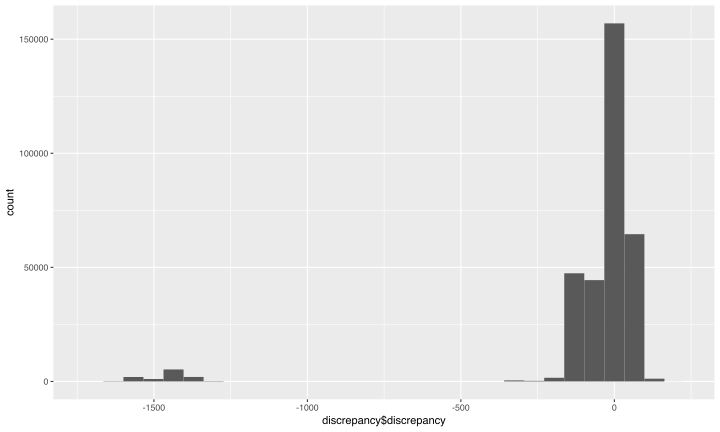

In [78]:
qplot(discrepancy$discrepancy, geom="histogram")  # shortcut ggplot function

We also have some negative values for total time for flight that departed late in the day and arrived early morning next day.

In [79]:
print(filter(my_flights_total, total_time < 0))

# A tibble: 10,633 x 11
    year month   day dep_time arr_time air_time origin  dest new_arr new_dep
   <int> <int> <int>    <int>    <int>    <dbl>  <chr> <chr>   <dbl>   <dbl>
 1  2013     1     1     1929        3      192    EWR   BQN       3    1169
 2  2013     1     1     1939       29       NA    JFK   DFW      29    1179
 3  2013     1     1     2058        8      159    EWR   TPA       8    1258
 4  2013     1     1     2102      146      199    EWR   SJU     106    1262
 5  2013     1     1     2108       25      354    EWR   SFO      25    1268
 6  2013     1     1     2120       16      160    LGA   FLL      16    1280
 7  2013     1     1     2121        6      143    EWR   MCO       6    1281
 8  2013     1     1     2128       26      338    JFK   LAX      26    1288
 9  2013     1     1     2134       20      152    EWR   FLL      20    1294
10  2013     1     1     2136       25      154    EWR   FLL      25    1296
# ... with 10,623 more rows, and 1 more variables: t

We can fix the negative values by adding 24\*60 to them (we keep the positive values as is).

Note that `transmute()` will only keep the new variables.

In [80]:
transmute(my_flights_total, arr_time, dep_time,
          new_total_time = (total_time < 0)*(total_time + 24*60) + 
          (total_time >= 0)*total_time) %>% print

# A tibble: 336,776 x 3
   arr_time dep_time new_total_time
      <int>    <int>          <dbl>
 1      830      517            193
 2      850      533            197
 3      923      542            221
 4     1004      544            260
 5      812      554            138
 6      740      554            106
 7      913      555            198
 8      709      557             72
 9      838      557            161
10      753      558            115
# ... with 336,766 more rows


A nice feature of `mutate()`/`transmute()` is that you can use columns defined earlier in the command:

In [81]:
print(mutate(flights, gain = arr_delay - dep_delay, gain_per_hour = gain / (air_time / 60)))

# A tibble: 336,776 x 21
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# ... with 336,766 more row

## Grouped Summaries
`summarize()` can be used to summarize entire data frames by collapsing them into single number summaries. As opposed to `mutate()`, which generates a new column and entry for each row, `summarize()` first groups columns and then applies a summary function.

The most basic use of summarize is to compute statistics over the whole data set:

In [82]:
summarize(flights, delay = mean(dep_delay, na.rm = TRUE))
# Equivalently:
mean(flights$dep_delay, na.rm=TRUE)

delay   
1 12.63907

[1] 12.63907

Here we used the `na.rm=TRUE` option to tell R to ignore entries with missing `dep_delay` when calculating the mean. If we did not do this we would get `NA`s:

In [83]:
summarize(flights, delay = mean(dep_delay, na.rm = FALSE))  # the default

delay
1 NA

`na.rm=TRUE` is equivalent to dropping the missing entries and then calculating the mean:

In [84]:
filter(flights, !is.na(dep_delay)) %>% summarize(delay=mean(dep_delay))

delay   
1 12.63907

### Grouping observations
`summarize()` is most useful when combined with `group_by()` to group observations before calculating the summary statistic. The `group_by` function tells R how your data are grouped:

In [85]:
print(by_month <- group_by(flights, year, month))  # must use <- here :)

# A tibble: 336,776 x 19
# Groups:   year, month [12]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            74

In [107]:
summarize(by_month, mean(dep_delay, na.rm=T)) %>% print

# A tibble: 12 x 3
# Groups:   year [?]
    year month `mean(dep_delay, na.rm = T)`
   <int> <int>                        <dbl>
 1  2013     1                    10.036665
 2  2013     2                    10.816843
 3  2013     3                    13.227076
 4  2013     4                    13.938038
 5  2013     5                    12.986859
 6  2013     6                    20.846332
 7  2013     7                    21.727787
 8  2013     8                    12.611040
 9  2013     9                     6.722476
10  2013    10                     6.243988
11  2013    11                     5.435362
12  2013    12                    16.576688


Many summary functions are available:

* Center: `mean(), median()`
* Spread: `sd(), IQR(), mad()`
* Range: `min(), max(), quantile()`
* Position: `first(), last(), nth()`
* Count: `n(), n_distinct()`
* Logical: `any(), all()`

### Examples
Compute the number of flights each month:

In [87]:
group_by(flights, month) %>% summarize(n())

month n()  
1   1    27004
2   2    24951
3   3    28834
4   4    28330
5   5    28796
6   6    28243
7   7    29425
8   8    29327
9   9    27574
10 10    28889
11 11    27268
12 12    28135

### Always include counts
This operation is so common that we have a special shortcut for it:

In [88]:
group_by(flights, month) %>% count

month n    
1   1    27004
2   2    24951
3   3    28834
4   4    28330
5   5    28796
6   6    28243
7   7    29425
8   8    29327
9   9    27574
10 10    28889
11 11    27268
12 12    28135

One of the reasons for the `count()` shortcut is that it is always a good idea to add counts when do you a summary. This is because some groups may have very low numbers of observations, resulting in high variance for the summary statistics. For example, let's look at particular airplanes which have high delays, perhaps due to maintenance, etc:

In [89]:
not_cancelled = flights %>% filter(!is.na(dep_delay), !is.na(arr_delay))
not_cancelled %>% group_by(tailnum) %>% summarise(delay = mean(arr_delay)) %>% 
                  top_n(5)

Selecting by delay


tailnum delay
1 N587NW  264  
2 N844MH  320  
3 N851NW  219  
4 N911DA  294  
5 N922EV  276

The top five most delayed planes experience an average delay of 4-5 hours! Clearly this is not realistic. The issue is that there are very few observations for each of these planes:

In [90]:
delays = not_cancelled %>% group_by(tailnum) %>% summarise(delay=mean(arr_delay), obs=n())
top_n(delays, 5, delay)

tailnum delay obs
1 N587NW  264   1  
2 N844MH  320   1  
3 N851NW  219   1  
4 N911DA  294   1  
5 N922EV  276   1

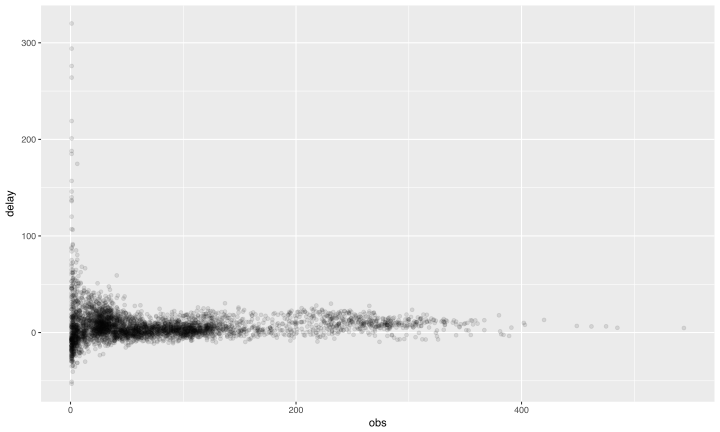

In [91]:
ggplot(delays) + geom_point(aes(x=obs, y=delay), alpha=.1) 

The solution is to filter to only those planes that had sufficiently many observations:

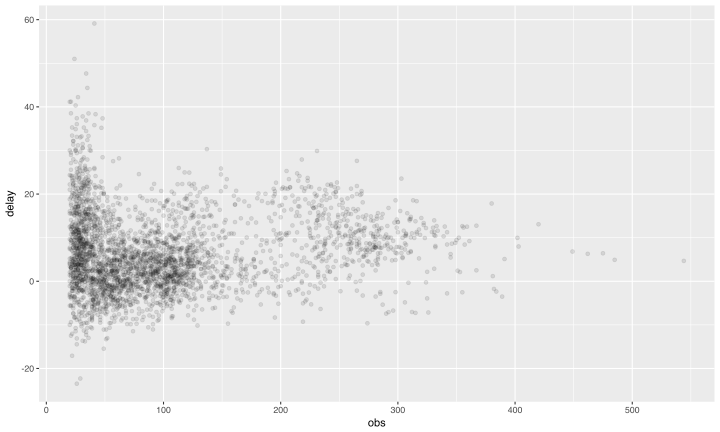

In [92]:
ggplot(filter(delays, obs >= 20)) + geom_point(aes(x=obs, y=delay), alpha=.1) 

Something similar occurs if we start sorting by an average: ignoring the standard error of the estimated average can cause spurious extreme values to rise to the top.

In [93]:
# Convert to a tibble so it prints nicely
# H = hits; AB = at bats
# ba =
batters <- as_tibble(Lahman::Batting) %>% group_by(playerID) %>% summarise(
    batting_average = sum(H, na.rm = TRUE) / sum(AB, na.rm = TRUE),
    at_bats = sum(AB, na.rm = TRUE) )
batters %>% filter(at_bats > 100) %>%
            ggplot(mapping = aes(x = at_bats, y = batting_average)) + 
                  geom_point() + geom_smooth(se = FALSE)

`geom_smooth()` using method = 'gam'


Clearly better players get more at-bats. Who are the best players? If we sort by batting average, we see:

In [94]:
batters %>% arrange(desc(batting_average)) %>% print

# A tibble: 18,915 x 3
    playerID batting_average at_bats
       <chr>           <dbl>   <int>
 1 abramge01               1       1
 2 banisje01               1       1
 3 bartocl01               1       1
 4  bassdo01               1       1
 5 berrijo01               1       1
 6 birasst01               1       2
 7 bruneju01               1       1
 8 burnscb01               1       1
 9 cammaer01               1       1
10  campsh01               1       1
# ... with 18,905 more rows


To get a better estimate we should restrict to people who had at least 100 at-bats, say:

In [95]:
batters %>% arrange(desc(batting_average)) %>% filter(at_bats >= 1000) %>% print

# A tibble: 3,693 x 3
    playerID batting_average at_bats
       <chr>           <dbl>   <int>
 1  cobbty01       0.3663635   11434
 2 barnero01       0.3591137    2392
 3 hornsro01       0.3584975    8173
 4 jacksjo01       0.3557519    4981
 5 meyerle01       0.3555094    1443
 6 odoulle01       0.3492647    3264
 7 delahed01       0.3459027    7505
 8 mcveyca01       0.3458018    2513
 9 speaktr01       0.3446788   10195
10 willite01       0.3444070    7706
# ... with 3,683 more rows


### Some other examples of aggregation
Compute the number of unique destinations each day of the month:

In [96]:
group_by(flights, day) %>% summarize(n_distinct(dest)) %>% print

# A tibble: 31 x 2
     day `n_distinct(dest)`
   <int>              <int>
 1     1                 96
 2     2                101
 3     3                 97
 4     4                 96
 5     5                100
 6     6                 99
 7     7                 96
 8     8                 95
 9     9                101
10    10                 97
# ... with 21 more rows


Dispersion of departure delays by carrier:

In [97]:
group_by(flights, carrier) %>% summarize(n=n(),
                                         dep_iqr=IQR(dep_delay, na.rm=T), 
                                         arr_iqr=IQR(arr_delay, na.rm=T)) %>% arrange(n)

carrier n     dep_iqr arr_iqr
1  OO         32 13      22.00  
2  HA        342  6      30.50  
3  YV        601 30      40.25  
4  F9        685 22      40.00  
5  AS        714 10      34.00  
6  FL       3260 21      31.00  
7  VX       5162 12      31.00  
8  WN      12275 19      30.00  
9  9E      18460 23      36.00  
10 US      20536  7      23.00  
11 MQ      26397 16      31.00  
12 AA      32729 10      29.00  
13 DL      48110 10      28.00  
14 EV      54173 30      40.00  
15 B6      54635 17      31.00  
16 UA      58665 15      30.00

Worst-performing air-carrier (in terms of departure delay) each month of the year. This example is more challenging than the others. 

In [98]:
most_delayed = group_by(flights, carrier, month) %>% 
                   summarize(mean_dep_delay=mean(dep_delay, na.rm=T), obs=n()) %>%
                   group_by(month) %>% mutate(rank=min_rank(-mean_dep_delay)) %>%
                   arrange(month, rank) %>% filter(rank==1) %>% print

# A tibble: 12 x 5
# Groups:   month [12]
   carrier month mean_dep_delay   obs  rank
     <chr> <int>          <dbl> <int> <int>
 1      OO     1       67.00000     1     1
 2      F9     2       29.77083    49     1
 3      YV     3       31.88889    18     1
 4      YV     4       27.11111    38     1
 5      F9     5       35.94828    58     1
 6      OO     6       61.00000     2     1
 7      FL     7       41.16270   263     1
 8      OO     8       64.00000     4     1
 9      FL     9       16.94882   255     1
10      YV    10       20.00000    66     1
11      FL    11       16.86634   202     1
12      EV    12       27.88718  4307     1


Again note the issue here with low observation counts. In case you are curious what these carrier codes represent (who not to fly), we can use a *table join* (to be discussed later) to figure it out:

In [108]:
try({  
    # the try block prevents Run All Cells from stopping if you do not have the htmltab package installed
    # install.packages("htmltab")  # if necessary
    library(htmltab)
    carriers = htmltab(doc='http://aspmhelp.faa.gov/index.php/ASQP:_Carrier_Codes_and_Names', 
                       which='//table[1]') %>% rename(carrier="IATA Carrier Code")
    # we will learn about inner_join later
    inner_join(most_delayed, carriers, by='carrier')
    })

carrier month mean_dep_delay obs  rank ICAO Carrier Code
1 OO       1    67.00000          1 1    SKW              
2 F9       2    29.77083         49 1    FFT              
3 YV       3    31.88889         18 1    ASH              
4 YV       4    27.11111         38 1    ASH              
5 F9       5    35.94828         58 1    FFT              
6 OO       6    61.00000          2 1    SKW              
7 OO       8    64.00000          4 1    SKW              
8 YV      10    20.00000         66 1    ASH              
9 EV      12    27.88718       4307 1    CAA              
  Carrier Name               
1 SkyWest Airlines           
2 Frontier Airlines          
3 Mesa Airlines              
4 Mesa Airlines              
5 Frontier Airlines          
6 SkyWest Airlines           
7 SkyWest Airlines           
8 Mesa Airlines              
9 Atlantic Southeast Airlines

How does the situation change if we look at the median departure delay?

In [100]:
group_by(flights, carrier, month) %>% 
    summarize(median_dep_delay=median(dep_delay, na.rm=T), obs=n()) %>%
    group_by(month) %>% mutate(rank=min_rank(-median_dep_delay)) %>%
    arrange(month, rank) %>% filter(rank==1) %>% print

# A tibble: 12 x 5
# Groups:   month [12]
   carrier month median_dep_delay   obs  rank
     <chr> <int>            <dbl> <int> <int>
 1      OO     1             67.0     1     1
 2      EV     2              1.0  3827     1
 3      YV     3             15.5    18     1
 4      YV     4              9.0    38     1
 5      F9     5             13.5    58     1
 6      OO     6             61.0     2     1
 7      F9     7             16.0    58     1
 8      OO     8             56.0     4     1
 9      F9     9              2.0    58     1
10      FL    10              3.0   236     1
11      FL    11              6.0   202     1
12      WN    12              9.0  1099     1


Compared to the mean, the median departure delay looks less extreme.

### Transformations in summaries
We can combine transformations and summaries to get perform more complicated queries on the data. The following summary looks at the number of early-morning departures by month:

In [101]:
not_cancelled %>% group_by(month) %>% summarise(n_early = sum(dep_time < 500)) %>% print

# A tibble: 12 x 2
   month n_early
   <int>   <int>
 1     1      75
 2     2      84
 3     3     147
 4     4     148
 5     5     120
 6     6     219
 7     7     268
 8     8     135
 9     9      64
10    10      43
11    11      46
12    12     127


A red-eye (overnight) flight will have `dep_time > arr_time`. Here are the red-eyes by month:

In [102]:
not_cancelled %>% group_by(month) %>% summarise(n_redeye = sum(dep_time > arr_time)) %>% print

# A tibble: 12 x 2
   month n_redeye
   <int>    <int>
 1     1      713
 2     2      631
 3     3      949
 4     4     1019
 5     5      795
 6     6     1241
 7     7     1439
 8     8      933
 9     9      489
10    10      507
11    11      657
12    12     1163


How about by day of the week? This is harder because we need to figure out what day of the week each date is.

In [103]:
library(lubridate)
not_cancelled %>% mutate(date=ISOdate(year, month, day), day_of_week=wday(date, label=T)) %>%
                  group_by(day_of_week) %>% summarize(n_redeye=sum(dep_time > arr_time)) %>% 
                  arrange(desc(n_redeye)) %>% print

# A tibble: 7 x 2
  day_of_week n_redeye
        <ord>    <int>
1         Sun     1755
2         Thu     1705
3         Mon     1669
4         Fri     1659
5         Wed     1466
6         Tue     1360
7         Sat      922


## Pipes
The previous example made extensive use of the pipe operator `%>%`. Let's see why by rewriting that command without using pipes:

In [104]:
# option 1
filter(
    arrange(
        mutate(
            group_by(
                summarize(
                    group_by(flights, carrier, month),
                    mean_dep_delay=mean(dep_delay, na.rm=T)),
                month),
        rank=min_rank(-mean_dep_delay)), month, rank),
    rank==1)

carrier month mean_dep_delay rank
1  OO       1    67.00000       1   
2  F9       2    29.77083       1   
3  YV       3    31.88889       1   
4  YV       4    27.11111       1   
5  F9       5    35.94828       1   
6  OO       6    61.00000       1   
7  FL       7    41.16270       1   
8  OO       8    64.00000       1   
9  FL       9    16.94882       1   
10 YV      10    20.00000       1   
11 FL      11    16.86634       1   
12 EV      12    27.88718       1

In [105]:
# option 2
new_table = group_by(flights, carrier, month)
new_table1 = summarize(new_table, mean_dep_delay=mean(dep_delay, na.rm=T))
new_table2 = group_by(new_table1, month)
new_table3 = mutate(new_table2, rank=min_rank(-mean_dep_delay))
new_table4 = arrange(new_table3,  month, rank)
new_table5 = filter(new_table4, rank==1)
new_table5

carrier month mean_dep_delay rank
1  OO       1    67.00000       1   
2  F9       2    29.77083       1   
3  YV       3    31.88889       1   
4  YV       4    27.11111       1   
5  F9       5    35.94828       1   
6  OO       6    61.00000       1   
7  FL       7    41.16270       1   
8  OO       8    64.00000       1   
9  FL       9    16.94882       1   
10 YV      10    20.00000       1   
11 FL      11    16.86634       1   
12 EV      12    27.88718       1

Hopefully these examples convince you of the utility of `%>%`:
- In example 1, we have to declare operations in the reverse order of how they actually occur: the final `filter(rank==1)` command happens first! It is difficult to look at this code and understand what is being done.
- In example 2, we defined a series of auxiliary variables which clutter the workspace and serve no purpose once the final command is finished.

### How `%>%` works
Under the hood, `x %>% f(y)` turns into `f(x, y)`, and `x %>% f(y) %>% g(z)` turns into `g(f(x, y), z)` and so on. We can use `%>%` on any function, not just those defined in tidyverse:

In [106]:
2 %>% `*`(3)  # same as `*`(2,3) = 2 * 3
3 %>% `+`(4) %>% `*`(5)  # 5 * (3 + 4) = 35 -- _not_ 3 + (4 * 5) = 23
(4) %>% `*`(5) %>% `+`(3) 

[1] 6

[1] 35

[1] 23

**Note** that chaining the `%>%` operator evaluates right-to-left. This is the natural order for data processing pipelines.